In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy import constants as const
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.differentiate import derivative
from scipy.interpolate import griddata

**PROBLEM 2**
------------------------------------------------------------------------

Before beginning, let's quickly set up all the global variables and functions we'll need to complete the upcoming parts 

In [2]:
#INITILIZE NEEDED GLOBAL VARIABLES
I = 9.1*10**(-41)*u.cm**2 *u.g
w_vib = 5.4*10**14 * u.Hz
E_ion = 13.6*u.eV
m_H = const.m_p + const.m_e
n_array = np.linspace(0, 100, 101)
#--------------------------------------------------------------------------------------------------------------------------------------
#Arrays spanning given temperature and pressure ranges
temp_array = np.logspace(3, 4, 100)
pressure_array = np.logspace(3.5, 9, 100)
#--------------------------------------------------------------------------------------------------------------------------------------
#Setting up empty matrices for future parts
X_HI_matrix = np.full([len(temp_array), len(pressure_array)], np.nan)
X_HII_matrix = np.full([len(temp_array), len(pressure_array)], np.nan)
#--------------------------------------------------------------------------------------------------------------------------------------


In [3]:
#In this cell, we are intializing all the partition functions for H2:
def Z_tra(T, P, mu=1): 
    return (2*np.pi*mu*const.m_p*const.k_B*T*u.K / const.h**2)**(3/2) * (const.k_B * T*u.K) / (P*u.erg / u.cm**3)

def Z_H2_rot(T, j):
    T = np.atleast_1d(T).reshape(-1, 1)  # This is needed for future parts:
    j = np.atleast_1d(j).reshape(1, -1)  # When we differentiate later, lists will be passed thru these functions
                                         # and will not work unless inputted as array
    
    Z_rot = (2*j + 1)*np.exp(-(j*(j+1))*const.hbar**2 / (I*const.k_B*T*u.K)).value
    return Z_rot.squeeze()

def Z_H2_elec(T):
    T = np.asarray(T)
    return 1 + np.exp(-4.52*u.eV/(const.k_B*T*u.K))

def Z_H2_vib(T, n):
    T = np.atleast_1d(T).reshape(-1, 1)  
    n = np.atleast_1d(n).reshape(1, -1)
    Z_vib = np.exp(-(n+0.5)*const.hbar*w_vib / (const.k_B * T*u.K))
    return Z_vib.squeeze()

In [4]:
#Here we are intializing the electronic partition function for HI
def Z_HI_elec(T, P):
    E_ion = 13.6*u.eV
    n_max = (((const.k_B*T*u.K)**(1/3) / (2*((P*u.erg/u.cm**3)**(1/3))*const.a0))**(1/2)).decompose()
    n_max = np.mean(n_max) #This is another method to avoid complications with inputted arrays or lists
    n_max = int(n_max)
    n_max_array = np.linspace(1, n_max, n_max)

    Z_elec_HI = 0
    for n in n_max_array:
        Z_elec_HI += 4*(n**2)*np.exp((-E_ion*(1-(1/n**2))/ (const.k_B*T*u.K)))
        
    return Z_elec_HI

Part 2:
-------------------------
- Now that we've initialized all our needed partition functions let's compute the ionization fraction of HI!
- Using the result of my derivation in my written work pdf we can intialize a function uses all our partition functions from before!

In [5]:
def X_HI(T,P):
    
    sum_Z_HI_elec = Z_HI_elec(T,P)
    sum_Z_H2_elec = Z_H2_elec(T)
    sum_Z_H2_vib = np.sum(Z_H2_vib(T, n_array))
    sum_Z_H2_rot = np.sum(Z_H2_rot(T, n_array[0:100:2])) + 3*np.sum(Z_H2_rot(T, n_array[1:100:2]))

    C = (np.pi*const.m_p *const.k_B *T* u.K/ const.h**2)**(3/2) * const.k_B * T*u.K * sum_Z_HI_elec**2 * np.exp(-4.52*u.eV/ (const.k_B*T*u.K)) / ((P*u.erg/u.cm**3)*sum_Z_H2_elec*sum_Z_H2_vib*sum_Z_H2_rot)
    
    x = (-C + (C**2 + 4*C)**(1/2)) / 2

    return x

Now with our function, lets fill in our empty array from the set up section by looping through each row and column

In [6]:
for i, P in enumerate(pressure_array):
    for j, T in enumerate(temp_array):
        X_HI_matrix[i,j] = X_HI(T,P)

Done! Now lets see what it looks like!

In [7]:
X_HI_matrix

array([[9.05007912e-08, 1.64278117e-07, 2.94234563e-07, ...,
        9.99999710e-01, 9.99999747e-01, 9.99999779e-01],
       [8.48935313e-08, 1.54099752e-07, 2.76004341e-07, ...,
        9.99999670e-01, 9.99999712e-01, 9.99999749e-01],
       [7.96336868e-08, 1.44552020e-07, 2.58903630e-07, ...,
        9.99999625e-01, 9.99999673e-01, 9.99999714e-01],
       ...,
       [1.82897577e-10, 3.31997877e-10, 5.94633410e-10, ...,
        9.37440807e-01, 9.44619422e-01, 9.50925518e-01],
       [1.71565584e-10, 3.11427908e-10, 5.57791033e-10, ...,
        9.30024254e-01, 9.37947869e-01, 9.44929719e-01],
       [1.60935701e-10, 2.92132416e-10, 5.23231342e-10, ...,
        9.21864450e-01, 9.30583105e-01, 9.38290947e-01]])

Turns out, a 100x100 matrix is a bit too big to fully print...
Lets make a heat map to better visualize!

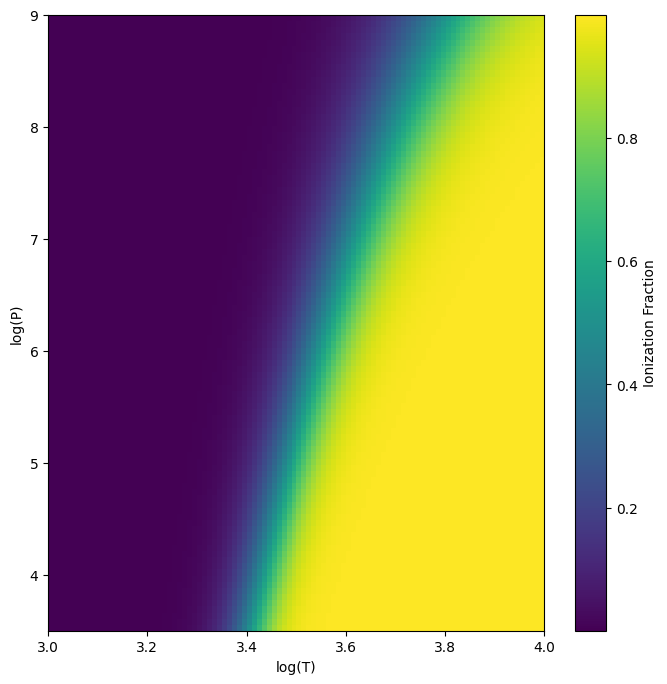

In [8]:
#lets quickly plot it!
plt.figure(figsize=[8,8])
plt.imshow(X_HI_matrix, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
plt.xlabel("log(T)")
plt.ylabel("log(P)")
plt.colorbar(label="Ionization Fraction")

Part 3
----------------------------------------------------
Computing the ionization fraction for HII is the same process as HI, except now our big C will be slightly different!

In [9]:
def X_HII(T,P):
    
    sum_Z_HI_elec = Z_HI_elec(T,P)
    
    if sum_Z_HI_elec == 0:
        return np.nan

    C_T = (const.k_B*T*u.K / (P*u.erg / u.cm**3)) * (2*np.pi*const.k_B*T*u.K / (const.h**2))**(3/2) * (const.m_p * const.m_e / m_H)**(3/2) * (4/sum_Z_HI_elec) * np.exp(-E_ion / (const.k_B * T*u.K))

    frac = (-C_T + (C_T**2 + 4*C_T)**(1/2)) / 2

    return frac

In [10]:
for i, P in enumerate(pressure_array):
    for j, T in enumerate(temp_array):
        X_HII_matrix[i,j] = X_HII(T,P)

In [11]:
X_HII_matrix

array([[3.09601248e-33, 1.95573060e-32, 1.18495529e-31, ...,
        2.19705688e-01, 2.65377949e-01, 3.17111623e-01],
       [2.90418932e-33, 1.83455718e-32, 1.11153767e-31, ...,
        2.07675746e-01, 2.51308177e-01, 3.00961002e-01],
       [2.72425117e-33, 1.72089145e-32, 1.04266887e-31, ...,
        1.96216688e-01, 2.37854202e-01, 2.85443982e-01],
       ...,
       [6.25688622e-36, 3.95243364e-35, 2.39473532e-34, ...,
        5.02635480e-04, 6.25735377e-04, 7.75576085e-04],
       [5.86922123e-36, 3.70754823e-35, 2.24636199e-34, ...,
        4.71500467e-04, 5.86977363e-04, 7.27540325e-04],
       [5.50557524e-36, 3.47783546e-35, 2.10718159e-34, ...,
        4.42293640e-04, 5.50619357e-04, 6.82478672e-04]])

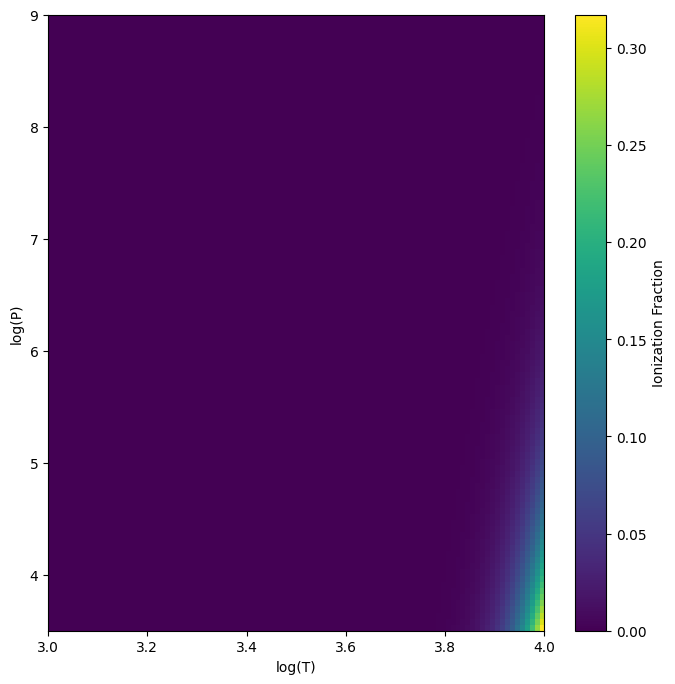

In [12]:
plt.figure(figsize=[8,8])
plt.imshow(X_HII_matrix, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
plt.xlabel("log(T)")
plt.ylabel("log(P)")
plt.colorbar(label="Ionization Fraction")

PART 4
------
- We wish to compute the specific entropy of each species
- Using the derivation from my handwritten work (seperate pdf), we now need to formally compute the helmholtz energy and differentiate with respect to T to find specific entropy

First, we'll create a function to compute the helmholtz energy for each species.
- notice our functions are returning another function, with only a dependance on T.
- This is known as a wrapper function and is needed in order to use scipy.differentiate.derivative (which only takes functions with one input parameter)
- With this wrapper function, we are able to specify all our constants (like P and xHI) but still feed the wrapper into scipy.differentiate.derivative

In [13]:
def F_HII(P, X_HII):

    def wrapper(T):
        return (const.k_B.cgs*T*u.K / m_H.cgs) * np.log((2*const.k_B.cgs*T*u.K/(X_HII*P*u.erg/u.cm**3))*(2*np.pi*const.m_p.cgs*const.k_B.cgs*T*u.K/const.h.cgs**2)**(3/2))
        
    return wrapper

def F_HI(P, X_HI):

    def wrapper(T):
        Z_tot = Z_HI_elec(T, P)
        return ((const.k_B.cgs*T*u.K / m_H.cgs) * np.log(Z_tot*(const.k_B.cgs*T*u.K/(X_HI*P*u.erg/u.cm**3))*(2*np.pi*const.m_p.cgs*const.k_B.cgs*T*u.K/const.h.cgs**2)**(3/2)))

    return wrapper

def F_H2(P, xHI):

    def wrapper(T):
        x = (1 - xHI)
        z = Z_H2_elec(T) * np.sum(Z_H2_vib(T, n_array)) * (np.sum(Z_H2_rot(T, n_array[0:100:2])) + 3*np.sum(Z_H2_rot(T, n_array[1:100:2])))
        return const.k_B.cgs * T*u.K / (2 * const.m_p.cgs) * np.log(z*(const.k_B.cgs *T*u.K) / (P*u.erg*u.cm**(-3) * x) * (4 * np.pi * const.m_p.cgs * const.k_B.cgs * T*u.K / const.h.cgs**2)**(3/2))

    return wrapper

Now with each specific helmholtz function ready, we can find the specific entropy with derivative()

In [15]:
S_HII_matrix = np.full([len(temp_array), len(pressure_array)], np.nan)

for i, P in enumerate(pressure_array):
    for j, T in enumerate(temp_array):
        eep = F_HII(P, X_HII_matrix[i,j])
        S_HII = derivative(eep, T)
        S_HII_matrix[i,j] = S_HII.df

S_HII_matrix

array([[8.03816122e+09, 7.89089313e+09, 7.74706589e+09, ...,
        2.45301099e+09, 2.44222670e+09, 2.43233072e+09],
       [8.03288452e+09, 7.88561643e+09, 7.74178919e+09, ...,
        2.44710319e+09, 2.43616745e+09, 2.42608981e+09],
       [8.02760782e+09, 7.88033974e+09, 7.73651250e+09, ...,
        2.44123231e+09, 2.43015332e+09, 2.41990349e+09],
       ...,
       [7.52632152e+09, 7.37905344e+09, 7.23522620e+09, ...,
        1.93094070e+09, 1.91766526e+09, 1.90475148e+09],
       [7.52104483e+09, 7.37377674e+09, 7.22994950e+09, ...,
        1.92566271e+09, 1.91238696e+09, 1.89947279e+09],
       [7.51576813e+09, 7.36850005e+09, 7.22467281e+09, ...,
        1.92038481e+09, 1.90710876e+09, 1.89419424e+09]])

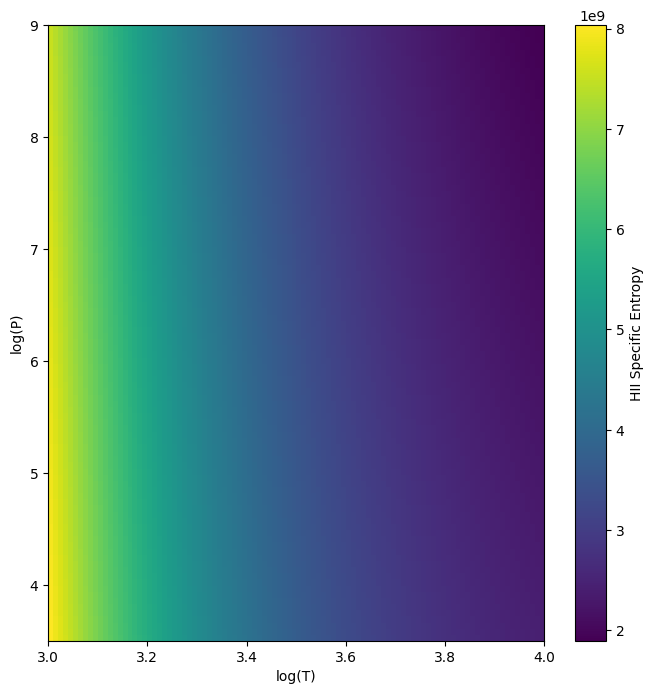

In [16]:
plt.figure(figsize=[8,8])
plt.imshow(S_HII_matrix, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
plt.xlabel("log(T)")
plt.ylabel("log(P)")
plt.colorbar(label="HII Specific Entropy")

In [17]:
S_HI_matrix = np.full([len(temp_array), len(pressure_array)], np.nan)

for i, P in enumerate(pressure_array):
    for j, T in enumerate(temp_array):
        eep = F_HI(P, X_HI_matrix[i,j])
        S_HI = derivative(eep, T)
        # print(S_HII)
        # print(type(S_HII))
        S_HI_matrix[i,j] = S_HI.df

S_HI_matrix

array([[3.25782383e+09, 3.21343470e+09, 3.17014988e+09, ...,
        2.38582147e+09, 2.39089462e+09, 2.39607379e+09],
       [3.25254713e+09, 3.20815800e+09, 3.16487318e+09, ...,
        2.37526808e+09, 2.38034123e+09, 2.38552039e+09],
       [3.24727043e+09, 3.20288130e+09, 3.15959648e+09, ...,
        2.36464870e+09, 2.36969352e+09, 2.37483337e+09],
       ...,
       [2.74598413e+09, 2.70159500e+09, 2.65831018e+09, ...,
        1.36684365e+09, 1.37101859e+09, 1.37527601e+09],
       [2.74070744e+09, 2.69631830e+09, 2.65303348e+09, ...,
        1.35694554e+09, 1.36104993e+09, 1.36524444e+09],
       [2.73543074e+09, 2.69104161e+09, 2.64775678e+09, ...,
        1.34711917e+09, 1.35114687e+09, 1.35527270e+09]])

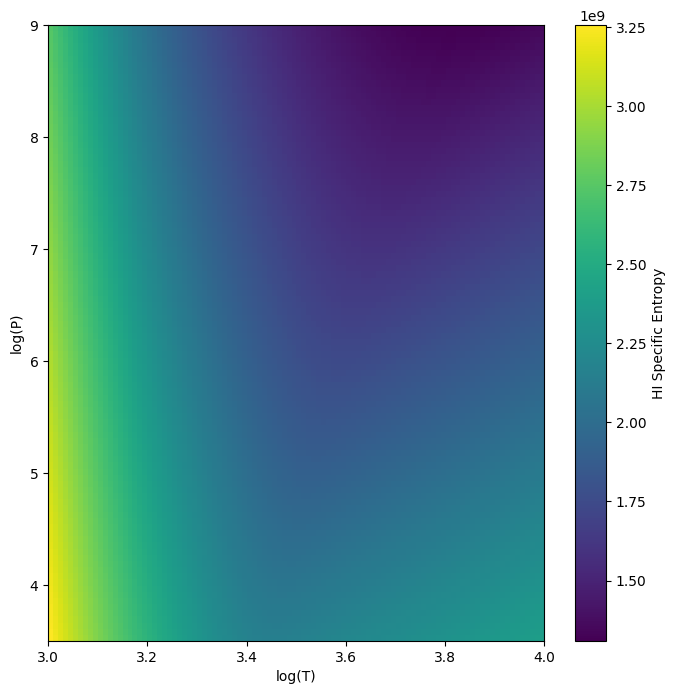

In [18]:
plt.figure(figsize=[8,8])
plt.imshow(S_HI_matrix, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
plt.xlabel("log(T)")
plt.ylabel("log(P)")
plt.colorbar(label="HI Specific Entropy")

In [20]:
S_H2_matrix = np.full([len(temp_array), len(pressure_array)], np.nan)

for i, P in enumerate(pressure_array):
    for j, T in enumerate(temp_array):
        eep = F_H2(P, X_HI_matrix[i,j])
        S_H2 = derivative(eep, T)
        S_H2_matrix[i,j] = S_H2.df

S_H2_matrix

array([[1.04881694e+09, 1.05417286e+09, 1.05948949e+09, ...,
        2.11469384e+09, 2.12481420e+09, 2.13485792e+09],
       [1.04353737e+09, 1.04889329e+09, 1.05420992e+09, ...,
        2.10414065e+09, 2.11424237e+09, 2.12428373e+09],
       [1.03825780e+09, 1.04361371e+09, 1.04893035e+09, ...,
        2.09354061e+09, 2.10368085e+09, 2.11371942e+09],
       ...,
       [5.36698492e+08, 5.42054404e+08, 5.47371031e+08, ...,
        1.09573993e+09, 1.10522448e+09, 1.11467725e+09],
       [5.31418921e+08, 5.36774832e+08, 5.42091459e+08, ...,
        1.08583643e+09, 1.09525038e+09, 1.10464021e+09],
       [5.26139349e+08, 5.31495260e+08, 5.36811888e+08, ...,
        1.07600470e+09, 1.08534194e+09, 1.09466304e+09]])

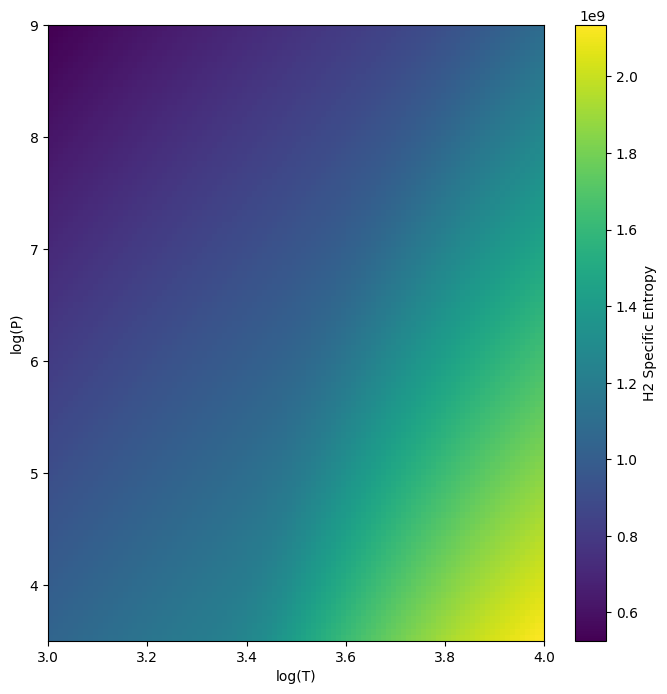

In [21]:
plt.figure(figsize=[8,8])
plt.imshow(S_H2_matrix, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
plt.xlabel("log(T)")
plt.ylabel("log(P)")
plt.colorbar(label="H2 Specific Entropy")

PART 5
------
- We wish to find the total specific entropy of the system
- We've already found the specific entropy of each species but need entropy of mixing to find total...
- To find calculate it, rather than make another function let's set up a matrix for entropy of mixing and fill it in using what we already have.

In [22]:
S_mixing_matrix = np.full([len(temp_array), len(pressure_array)], np.nan) * (u.erg / (u.K * u.g))

#We have the matrices for number fraction of HI and HII, lets quickly make one for H2 by subtracting the total by HI and HII
X_H2_matrix = 1 - X_HI_matrix

#With all our number fractions, now need the corresponding mass fraction from each species:
mass_H2_matrix = X_H2_matrix*2*const.m_p
mass_HI_matrix = X_HI_matrix*const.m_p
mass_HII_matrix = X_HII_matrix*const.m_p

#Remember, we found HII in terms of HI, NOT in terms of N_tot. Reflecting that, our mass fractions have to be defined as:
mfrac_H2_matrix = mass_H2_matrix / (mass_H2_matrix + mass_HI_matrix)
mfrac_HI_matrix = mass_HI_matrix / (mass_H2_matrix + mass_HI_matrix)
mfrac_HII_matrix = mass_HII_matrix / (mass_HII_matrix + mass_HI_matrix)

#We now have everything we need for S_mixing_matrix

fractions = [mfrac_H2_matrix, mfrac_HI_matrix, mfrac_HII_matrix]
mmws = [2, 1, 1]

for i, P in enumerate(pressure_array):
    for j, T in enumerate(temp_array):
        first_term = 0
        second_term = 0

        for fraction, mmw in zip(fractions, mmws):
            sum_term = (fraction[i,j]) / (mmw*const.m_p.cgs.value)
            first_term += sum_term
            second_term += sum_term * np.log(sum_term)

        S_mixing_matrix[i,j] = (const.k_B/u.g) * ((first_term * np.log(first_term)) - second_term)

In [33]:
S_mixing_matrix.

array([[6.43114438e+01, 1.12696602e+02, 1.94770652e+02, ...,
        4.16203351e+07, 4.60516489e+07, 5.03932389e+07],
       [6.05509276e+01, 1.06120921e+02, 1.83431619e+02, ...,
        4.03400413e+07, 4.47533084e+07, 4.91051214e+07],
       [5.70095214e+01, 9.99274533e+01, 1.72749988e+02, ...,
        3.90704168e+07, 4.34580748e+07, 4.78119069e+07],
       ...,
       [1.76802696e-01, 3.12765085e-01, 5.45883196e-01, ...,
        1.85490737e+07, 1.71941358e+07, 1.59470901e+07],
       [1.66301241e-01, 2.94209126e-01, 5.13533535e-01, ...,
        1.99186776e+07, 1.85055503e+07, 1.71938674e+07],
       [1.56422717e-01, 2.76751670e-01, 4.83097433e-01, ...,
        2.13317734e+07, 1.98691246e+07, 1.84995085e+07]])

Now we can calculate the total specific entropy by summing the indices of each specific entropy matrix (including our new S_mixing_matrix)

In [37]:
for i, P in enumerate(pressure_array):
    for j, T in enumerate(temp_array):
        S_total_matrix[i, j] = (mfrac_H2_matrix[i,j]*S_H2_matrix[i, j]) + (mfrac_HI_matrix[i, j] * S_HI_matrix[i, j]) + (mfrac_HII_matrix[i, j] * S_HII_matrix[i, j]) + S_mixing_matrix[i, j].value
        #Note how we are waiting each entropy matrix by the corresponding mass fraction at a specific T and P
        
S_total_matrix

array([[1.04881711e+09, 1.05417315e+09, 1.05949000e+09, ...,
        2.86930283e+09, 2.94913559e+09, 3.03208202e+09],
       [1.04353753e+09, 1.04889356e+09, 1.05421039e+09, ...,
        2.83641967e+09, 2.91436550e+09, 2.99587092e+09],
       [1.03825794e+09, 1.04361397e+09, 1.04893079e+09, ...,
        2.80415696e+09, 2.88010652e+09, 2.96000580e+09],
       ...,
       [5.36698493e+08, 5.42054404e+08, 5.47371032e+08, ...,
        1.35450451e+09, 1.36158736e+09, 1.36839434e+09],
       [5.31418921e+08, 5.36774833e+08, 5.42091460e+08, ...,
        1.34237926e+09, 1.34969198e+09, 1.35669475e+09],
       [5.26139350e+08, 5.31495261e+08, 5.36811889e+08, ...,
        1.33007499e+09, 1.33763644e+09, 1.34485447e+09]])

Now we can plot!

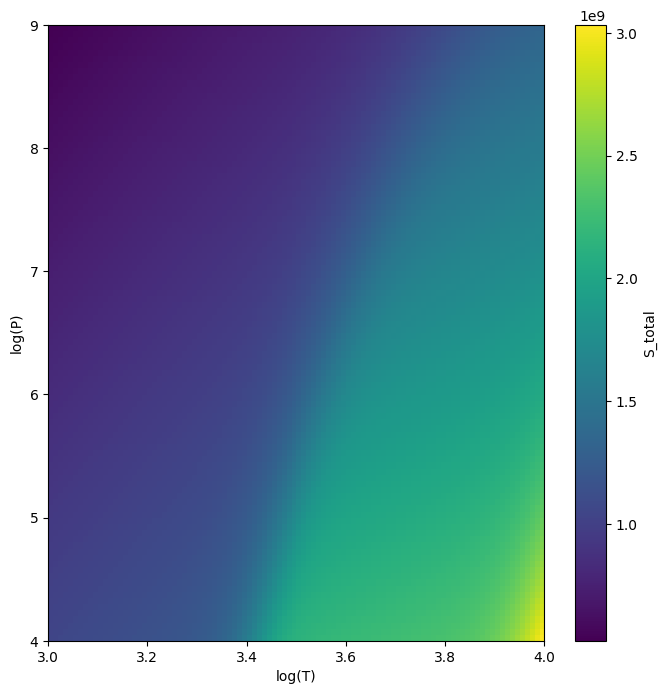

In [38]:
plt.figure(figsize=[8,8])
plt.imshow(S_total_matrix, origin='lower', interpolation="nearest", extent=[3, 4, 4, 9], aspect="auto")
plt.xlabel("log(T)")
plt.ylabel("log(P)")
plt.colorbar(label="S_total")

Now we need to compare our results to the provided data from SCvH
- Lets first extract their data through the provided .dat file

In [107]:
dat_T_array = np.linspace(2.10, 7.06, 63)
dat_P_array = np.linspace(4, 19, 76)
dat_matrix = np.full([len(dat_T_array), len(dat_P_array)], np.nan)
dat_adia_matrix = np.full([len(dat_T_array), len(dat_P_array)], np.nan)
dat_matrix.shape

#We can read the file with pd.read_csv however the data will not be correctly formmated
#Will need to so some extra work to extract their data
eep = pd.read_csv("h_tab_i.dat")

i = 0
j = 0
for index, row in eep.iterrows():
    
    if len(row.iloc[0]) == 9:
        i += 1
        j = 0
        #print("Temperature detected")

    else: 
        data_split = row.iloc[0].split("  ")
        entr = float(data_split[5])
        adia = float(data_split[-1])
        #print(entr)
        dat_matrix[i][j] = entr
        dat_adia_matrix[i][j] = adia
        j += 1

[[0.3142 0.3144 0.3144 ...    nan    nan    nan]
 [0.312  0.3121 0.3121 ...    nan    nan    nan]
 [0.3073 0.3074 0.3073 ...    nan    nan    nan]
 ...
 [0.4    0.4    0.4    ... 0.393  0.3935 0.3921]
 [0.4    0.4    0.4    ... 0.3943 0.3941 0.3925]
 [0.4    0.4001 0.4    ... 0.3955 0.3959 0.3954]]


Above, I was able to extract the entropy column and the adiabatic gradient column (which we'll need later)
- For now we're interested in the entropy column, we'll clip the data to fit within our T and P ranges to properly compare

In [118]:
dat_T_array_clipped = dat_T_array[11:24]
dat_P_array_clipped = dat_P_array[0:26]

dat_matrix_clipped = np.full([len(dat_T_array_clipped), len(dat_P_array_clipped)], np.nan) 

dat_matrix_clipped = dat_matrix[11:24, 0:26]
dat_matrix_clipped = 10**dat_matrix_clipped

With this their data should be ready to plot

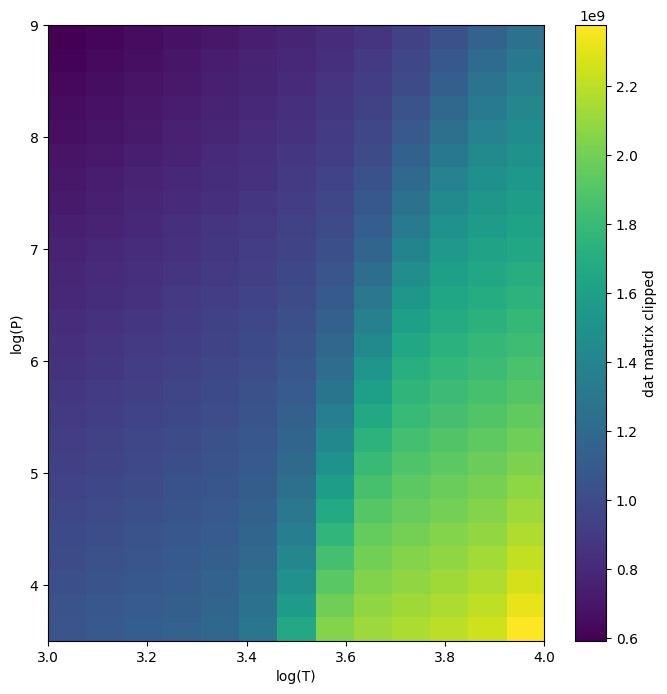

In [60]:
plt.figure(figsize=[8,8])
plt.imshow(dat_matrix_clipped.T, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
plt.xlabel("log(T)")
plt.ylabel("log(P)")
plt.colorbar(label="dat matrix clipped")

We now have both our calculations as well as their data, to properly we must consider interpolation 
- We do so by using scipy's griddata() function.
- Although this function is very handy, IT IS NOT INTUITIVE TO USE WITH A MATRIX OF DATA!
- To use it properly, we must use np.meshgrid() on ours and SCvH's T and P ranges in order to make a rectangular grid, then flatten the grids
- then flatten the corresponding entropy grid of SCvH, then we can finally use griddata()

In [85]:
X, Y = np.meshgrid(dat_T_array_clipped, dat_P_array_clipped)  
points = np.column_stack([X.ravel(), Y.ravel()])  

values = (dat_matrix_clipped).ravel()    

Tpt, Ppt = np.meshgrid(temp_array, pressure_array)       

SCvH_interp = griddata(points, values, (Tpt, Ppt), method = 'nearest')  

diff = (S_total_matrix - SCvH_interp)/SCvH_interp    

We can finally plot the difference

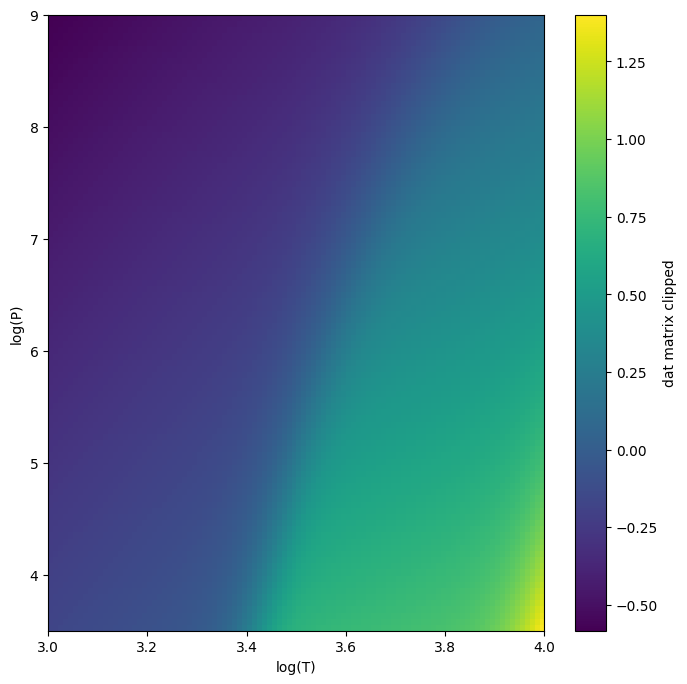

In [86]:
plt.figure(figsize=[8,8])
plt.imshow(diff, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
plt.xlabel("log(T)")
plt.ylabel("log(P)")
plt.colorbar(label="dat matrix clipped")

Since part 5 asks for subplots of the 3 graphs, they are provided below

Text(0, 0.5, 'Log(P)')

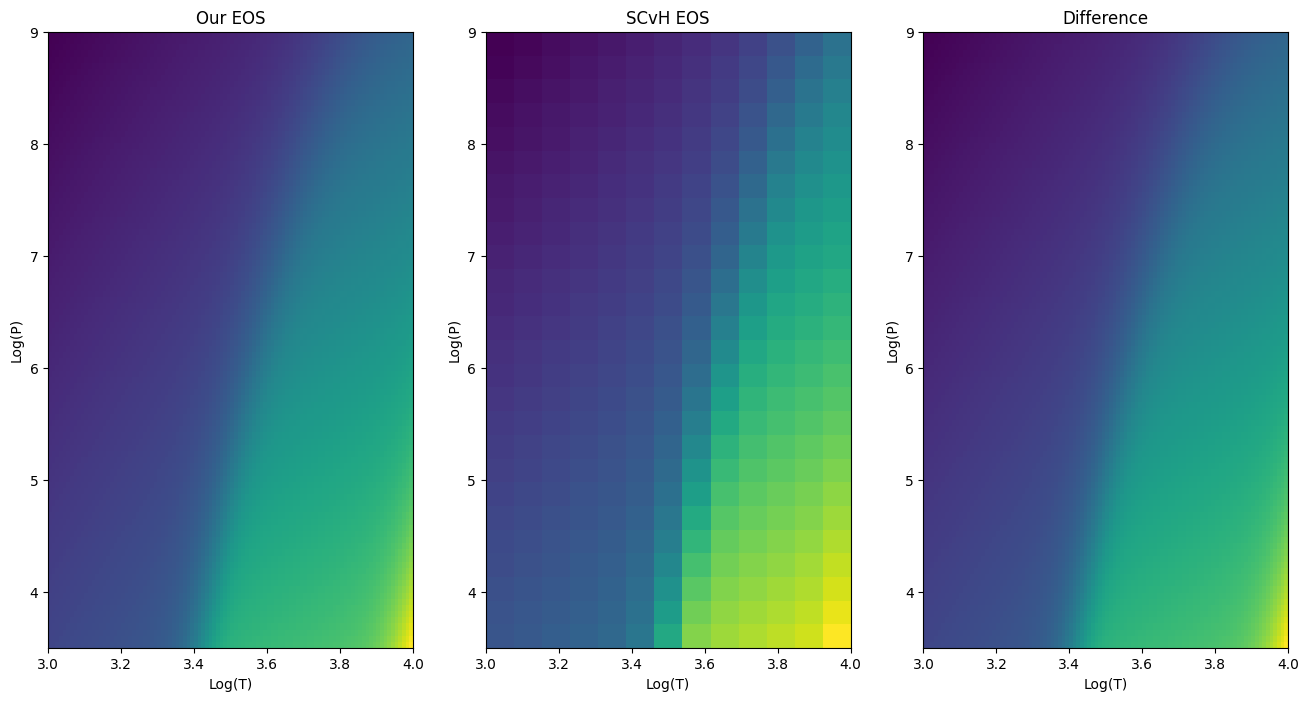

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8)) 

axs[0].imshow(S_total_matrix, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
axs[0].set_title('Our EOS')
axs[0].set_xlabel('Log(T)')
axs[0].set_ylabel('Log(P)')


axs[1].imshow(dat_matrix_clipped.T, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
axs[1].set_title('SCvH EOS')
axs[1].set_xlabel('Log(T)')
axs[1].set_ylabel('Log(P)')

axs[2].imshow(diff, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
axs[2].set_title('Difference')
axs[2].set_xlabel('Log(T)')
axs[2].set_ylabel('Log(P)')

Part 7
---------
- We now wish to consider the adiabatic temperature gradient
- To compute this, we'll need one more numpy function: np.gradient()

In [115]:
#np.gradient returns as many ndarrays as the dimensions of the matrix
dlogS_dlogP, dlogS_dlogT = np.gradient(np.log(S_total_matrix), np.log(pressure_array), np.log(temp_array))

#Calculating the adiabatic gradient means dividing 
adiagrad = - dlogS_dlogP / dlogS_dlogT 


#Now we need the extracted adiabatic gradient data from SCvH
#For transparency, this is simply the same interpolation code from part 5 but now with the adia_matrix
dat_adia_matrix_clipped = dat_adia_matrix[11:24, 0:26]

X, Y = np.meshgrid(dat_T_array_clipped, dat_P_array_clipped) 

points = np.column_stack([X.ravel(), Y.ravel()])  

values = (dat_adia_matrix_clipped).ravel()    

Tpt, Ppt = np.meshgrid(temp_array, pressure_array)       

dat_adia_interp = griddata(points, values, (Tpt, Ppt), method = 'nearest')  

#Where once again can calculate the difference once we have interpolated
adia_diff = (adiagrad - dat_adia_interp) / dat_adia_interp

Text(0, 0.5, 'Log(P)')

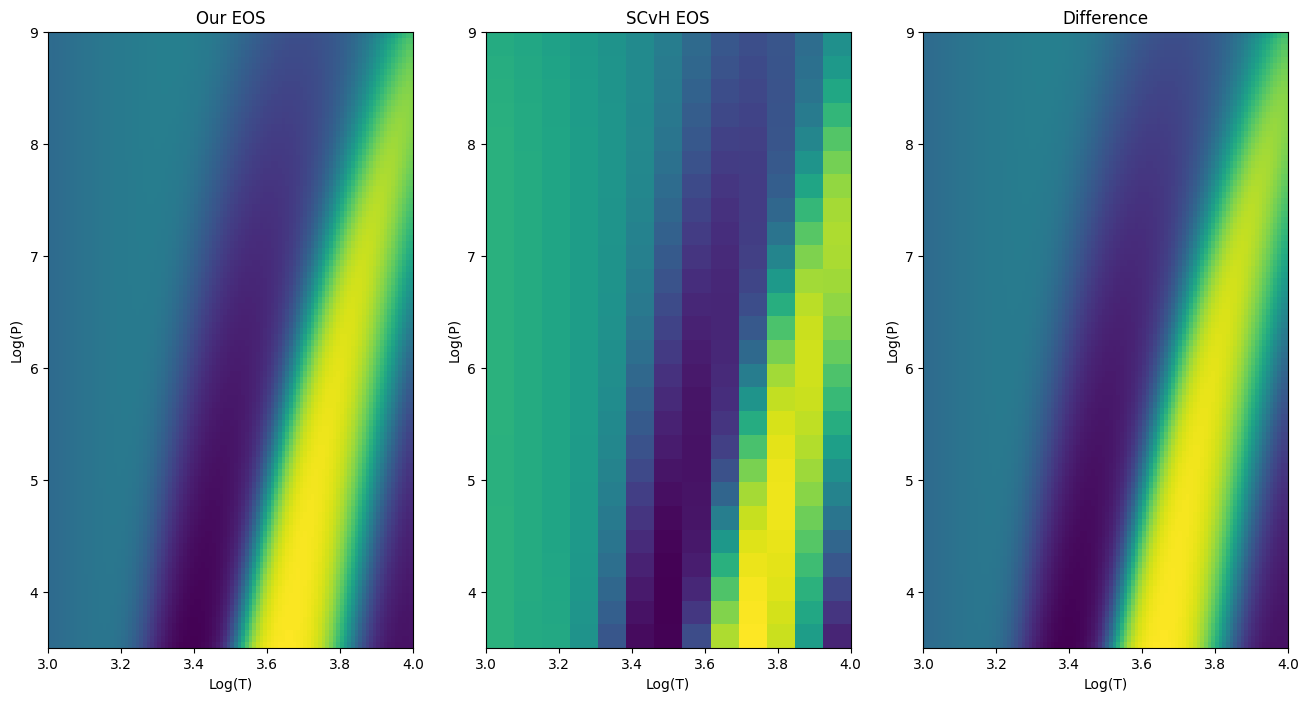

In [117]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8)) 

axs[0].imshow(adiagrad, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
axs[0].set_title('Our EOS')
axs[0].set_xlabel('Log(T)')
axs[0].set_ylabel('Log(P)')


axs[1].imshow(dat_adia_matrix_clipped.T, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
axs[1].set_title('SCvH EOS')
axs[1].set_xlabel('Log(T)')
axs[1].set_ylabel('Log(P)')

axs[2].imshow(adia_diff, origin='lower', interpolation="nearest", extent=[3, 4, 3.5, 9], aspect="auto")
axs[2].set_title('Difference')
axs[2].set_xlabel('Log(T)')
axs[2].set_ylabel('Log(P)')

References
-------------
This work was accomplished with close collaboration with **Marylin**, **Olivia** and Google